In [81]:
import pyNetLogo

In [82]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

#Determine Netlogo and model directory
jvm_home = '/Library/Java/JavaVirtualMachines/jdk1.8.0_121.jdk/Contents/MacOS/libjli.dylib'
Version = '6'
Home = '/Users/NenaRoes/Desktop/NetLogo 6.0.4'

netlogo = pyNetLogo.NetLogoLink(gui=True, jvm_home = jvm_home, netlogo_home = Home)
netlogo.load_model('./Model/Model-ToMRestrictedInfoTransparancy.nlogo')
netlogo.command('setup')


In [83]:
from __future__ import division, print_function
try:
    from itertools import izip as zip
except ImportError: # will be 3.x series
    pass

In [84]:
from SALib.sample import saltelli
from SALib.analyze import sobol

In [85]:
#Setting up the to be conducted experiments

problem = {
  'num_vars': 9,
  'names': ['random-seed',
            'NumStudents',
           'Similarity_Threshold',
           'PercBike',
           'PercCar',
            'Influence',
            'Sat',
            'BeliefUpdate',
            'Mean_deviation'
           ],
  'bounds': [[1, 100000],
             [5., 50.],
            [5., 25.],
            [10., 100.],
             [10., 100.],
             [1., 5.],
             [0.5, 5.],
             [0.05, 2.],
             [0.1, 4]]}

In [99]:
n = 100
param_values = saltelli.sample(problem, n, calc_second_order=True)

In [100]:
param_values.shape

(2000, 9)

In [101]:
## in terminal: ipcluster start -n 4
import ipyparallel

client = ipyparallel.Client()
client.ids

[0, 1, 2, 3]

In [102]:
direct_view = client[:]


In [103]:
import os

#Push the current working directory of the notebook to a "cwd" variable on the engines that can be accessed later
direct_view.push(dict(cwd=os.getcwd()))

<AsyncResult: _push>

In [104]:

direct_view.push(dict(problem=problem))

<AsyncResult: _push>

In [105]:
## Import model in all engines

%%px

import os
os.chdir(cwd)

import pyNetLogo
import pandas as pd
import numpy as np

jvm_home = '/Library/Java/JavaVirtualMachines/jdk1.8.0_121.jdk/Contents/MacOS/libjli.dylib'
Version = '6'
Home = '/Users/NenaRoes/Desktop/NetLogo 6.0.4'


netlogo = pyNetLogo.NetLogoLink(gui=True, jvm_home = jvm_home, netlogo_home = Home)
netlogo.load_model('./Model/Model-ToMRestrictedInfoTransparancy.nlogo')

In [106]:
#Specify Experiments

def simulation(experiment):

    #Set the input parameters
    for i, name in enumerate(problem['names']):
        if name == 'random-seed':
            #The NetLogo random seed requires a different syntax
            netlogo.command('random-seed {}'.format(experiment[i]))
        else:
            #Otherwise, assume the input parameters are global variables
            netlogo.command('set {0} {1}'.format(name, experiment[i]))

    netlogo.command('setup')
    #Run for 100 ticks and return the number of sheep and wolf agents at each time step
    counts = netlogo.repeat_report(['SocialGroupSA', 'mean_TotalTickChangeBel', 'PercInfluenced'], 100)

    results = pd.Series([counts['SocialGroupSA'].values.mean(),
                        counts['mean_TotalTickChangeBel'].values.mean(),
                        counts['PercInfluenced'].values.mean()],
                         index=['InfluenceGroup', 'Avg. Change Bliefs', 'Share Influenced'] )

    return results

In [107]:
#Run Experiments

lview = client.load_balanced_view()

results = pd.DataFrame(lview.map_sync(simulation, param_values))

In [108]:
results.head(5)

,InfluenceGroup,Avg. Change Bliefs,Share Influenced
0,0.992222,0.046878,0.222222
1,1.032222,0.047565,4.222222
2,1.003750,0.046019,1.250000
3,0.990000,0.046878,0.000000
4,0.998889,0.047038,0.777778


### Determine correlations for every output variable of interest

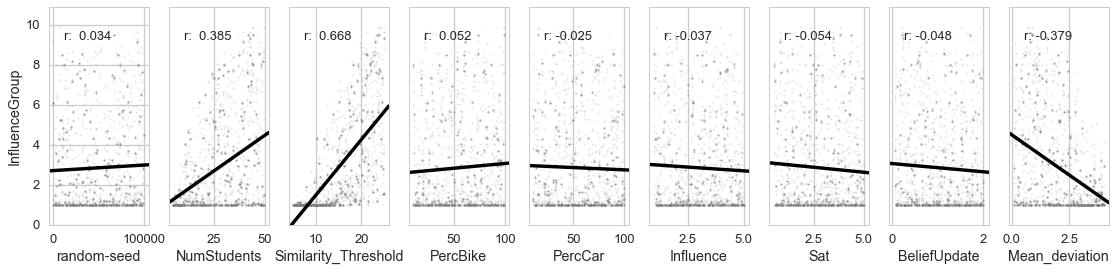

In [144]:
import scipy
import numpy as np


nrow=1
ncol=9


fig, ax = plt.subplots(nrow, ncol, sharey=True)

y = results['InfluenceGroup']

for i, a in enumerate(ax.flatten()):
    x = param_values[:,i]
    sns.regplot(x, y, ax=a, ci=None, color='k',scatter_kws={'alpha':0.2, 's':4, 'color':'gray'})
    pearson = scipy.stats.pearsonr(x, y)
    a.annotate("r: {:6.3f}".format(pearson[0]), xy=(0.15, 0.85), xycoords='axes fraction',fontsize=13)
    if divmod(i,ncol)[1]>0:
        a.get_yaxis().set_visible(False)
    a.set_xlabel(problem['names'][i])
    a.set_ylim([0,1.1*np.max(y)])

fig.set_size_inches(19,4,forward=True)
fig.subplots_adjust(wspace=0.2, hspace=0.3)

plt.savefig('ToMInfluenceGroup-correltions.jpg')
plt.show()

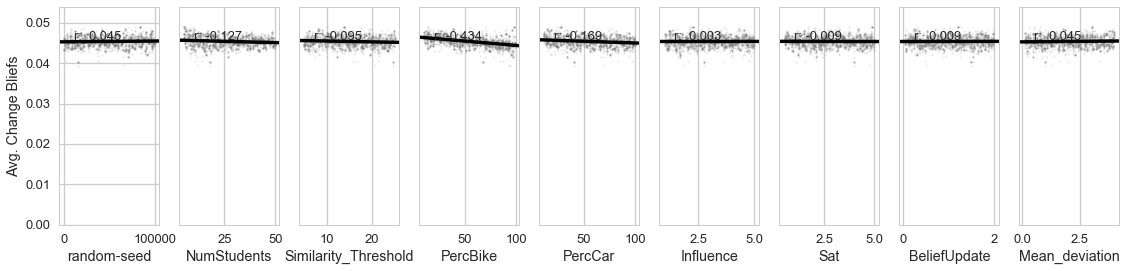

In [140]:
import scipy
import numpy as np


nrow=1
ncol=9

fig, ax = plt.subplots(nrow, ncol, sharey=True)

y = results['Avg. Change Bliefs']

for i, a in enumerate(ax.flatten()):
    x = param_values[:,i]
    sns.regplot(x, y, ax=a, ci=None, color='k',scatter_kws={'alpha':0.2, 's':4, 'color':'gray'})
    pearson = scipy.stats.pearsonr(x, y)
    a.annotate("r: {:6.3f}".format(pearson[0]), xy=(0.15, 0.85), xycoords='axes fraction',fontsize=13)
    if divmod(i,ncol)[1]>0:
        a.get_yaxis().set_visible(False)
    a.set_xlabel(problem['names'][i])
    a.set_ylim([0,1.1*np.max(y)])

fig.set_size_inches(19,4,forward=True)
fig.subplots_adjust(wspace=0.2, hspace=0.3)

plt.savefig('ToMAvg.Changebeliefs-correltions.jpg')
plt.show()

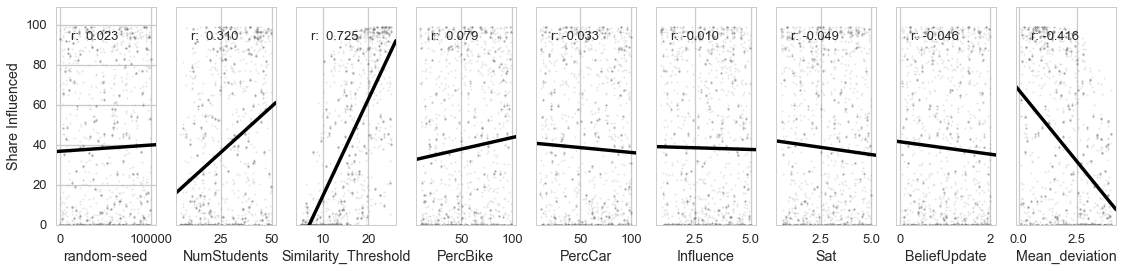

In [143]:
import scipy
import numpy as np


nrow=1
ncol=9

fig, ax = plt.subplots(nrow, ncol, sharey=True)

y = results['Share Influenced']

for i, a in enumerate(ax.flatten()):
    x = param_values[:,i]
    sns.regplot(x, y, ax=a, ci=None, color='k',scatter_kws={'alpha':0.2, 's':4, 'color':'gray'})
    pearson = scipy.stats.pearsonr(x, y)
    a.annotate("r: {:6.3f}".format(pearson[0]), xy=(0.15, 0.85), xycoords='axes fraction',fontsize=13)
    if divmod(i,ncol)[1]>0:
        a.get_yaxis().set_visible(False)
    a.set_xlabel(problem['names'][i])
    a.set_ylim([0,1.1*np.max(y)])

fig.set_size_inches(19,4,forward=True)
fig.subplots_adjust(wspace=0.2, hspace=0.3)

plt.savefig('ToMNumInfluenced.jpg')
plt.show()

### Determine Sobol Indexes

In [116]:
Si1 = sobol.analyze(problem, results['InfluenceGroup'].values, calc_second_order=True, print_to_console=False)
Si2 = sobol.analyze(problem, results['Avg. Change Bliefs'].values, calc_second_order=True, print_to_console=False)
Si3 = sobol.analyze(problem, results['Share Influenced'].values, calc_second_order=True, print_to_console=False)

In [117]:
Si1_filter = {k:Si1[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si1_df = pd.DataFrame(Si1_filter, index=problem['names'])
Si2_filter = {k:Si2[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si2_df = pd.DataFrame(Si2_filter, index=problem['names'])
Si3_filter = {k:Si3[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si3_df = pd.DataFrame(Si3_filter, index=problem['names'])

In [118]:
Si1_df

,ST,ST_conf,S1,S1_conf
random-seed,0.019872,0.010856,-0.017844,0.043552
NumStudents,0.364795,0.161233,0.146001,0.168667
Similarity_Threshold,0.631162,0.209210,0.564447,0.206594
PercBike,0.000052,0.000038,0.000148,0.001316
PercCar,0.000053,0.000029,0.000534,0.002193
Influence,0.000000,0.000000,0.000000,0.000000
Sat,0.000020,0.000025,0.000335,0.000868
BeliefUpdate,0.000000,0.000000,0.000000,0.000000
Mean_deviation,0.288613,0.136308,0.134360,0.125666


In [119]:
Si2_df

,ST,ST_conf,S1,S1_conf
random-seed,0.825397,0.313001,-0.212118,0.238513
NumStudents,0.849710,0.235548,0.057425,0.221144
Similarity_Threshold,0.027847,0.011089,0.033048,0.033061
PercBike,0.344518,0.133263,0.210893,0.201123
PercCar,0.233794,0.115779,0.115924,0.126721
Influence,0.000000,0.000000,0.000000,0.000000
Sat,0.025705,0.026133,0.044953,0.055452
BeliefUpdate,0.000000,0.000000,0.000000,0.000000
Mean_deviation,0.028507,0.017090,-0.012524,0.047166


In [120]:
Si3_df

,ST,ST_conf,S1,S1_conf
random-seed,0.058091,0.039032,-0.026900,0.062986
NumStudents,0.221724,0.117340,0.112897,0.126665
Similarity_Threshold,0.663992,0.211812,0.615372,0.208212
PercBike,0.000089,0.000058,-0.001656,0.002923
PercCar,0.000102,0.000083,-0.002875,0.002619
Influence,0.000000,0.000000,0.000000,0.000000
Sat,0.000016,0.000011,-0.000688,0.001285
BeliefUpdate,0.000000,0.000000,0.000000,0.000000
Mean_deviation,0.325331,0.115690,0.177902,0.153219


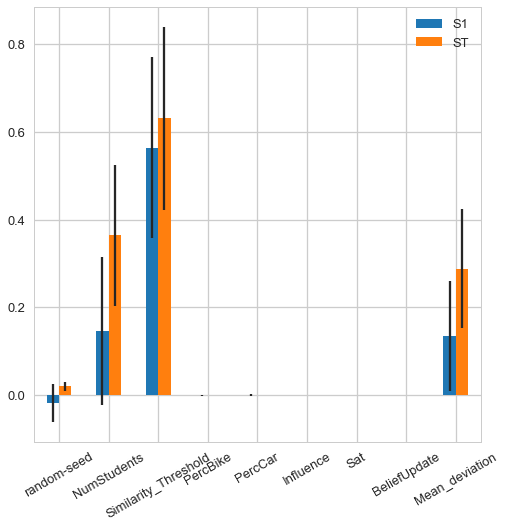

In [121]:
fig, ax = plt.subplots(1)

indices = Si1_df[['S1','ST']]
err = Si1_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,8)

plt.xticks(rotation=30)
plt.savefig('ToMGroupsize-sobol.jpg')
plt.show()

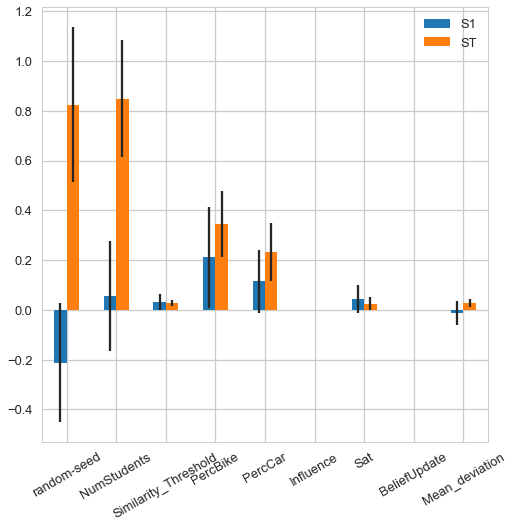

In [122]:
fig, ax = plt.subplots(1)

indices = Si2_df[['S1','ST']]
err = Si2_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,8)

plt.xticks(rotation=30)
plt.savefig('ToMAvChangebeliefs-sobol.jpg')
plt.show()

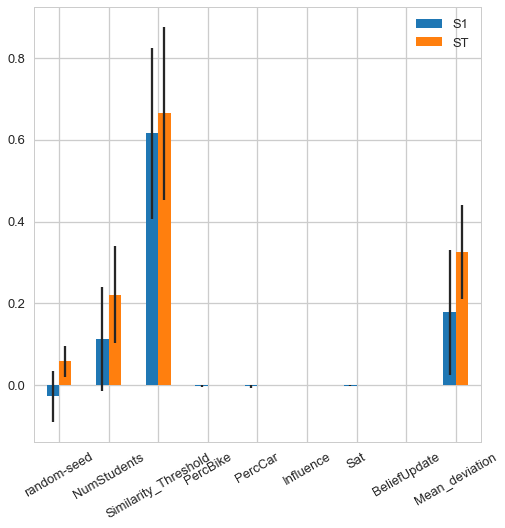

In [123]:
fig, ax = plt.subplots(1)

indices = Si3_df[['S1','ST']]
err = Si3_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,8)

plt.xticks(rotation=30)
plt.savefig('ToMInfluencedstudents.jpg')
plt.show()

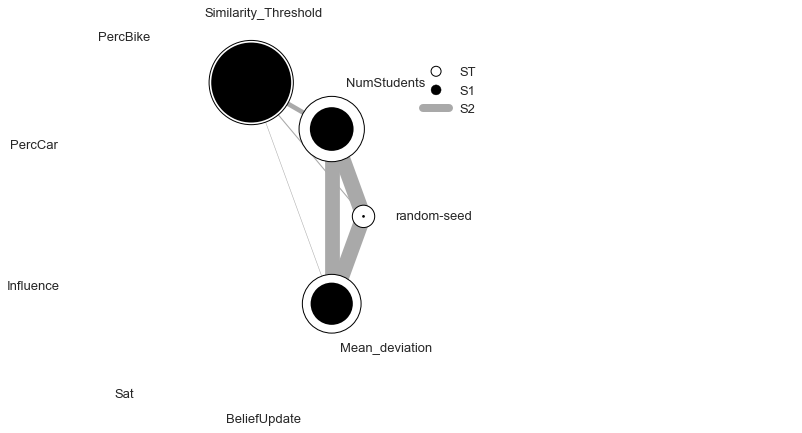

In [124]:
%matplotlib inline
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):

    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})


sns.set_style('whitegrid')
fig = plot_sobol_indices(Si1, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)

plt.savefig('ToMGROUP.jpg')
plt.show()

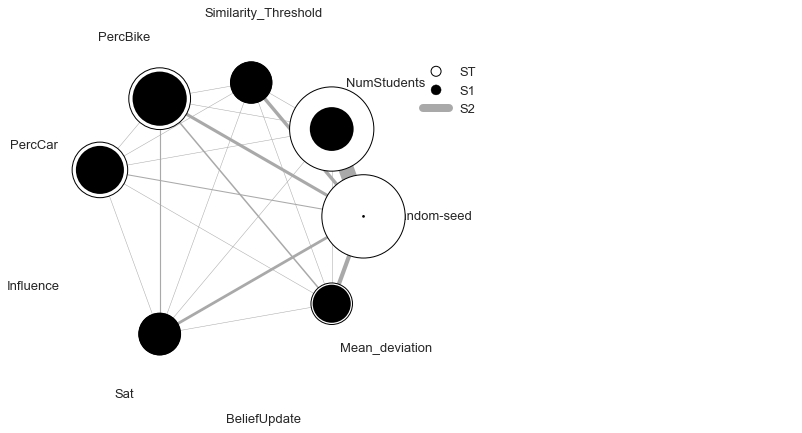

In [125]:
%matplotlib inline
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):

    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})


sns.set_style('whitegrid')
fig = plot_sobol_indices(Si2, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)

plt.savefig('ToMBELIEF.jpg')
plt.show()

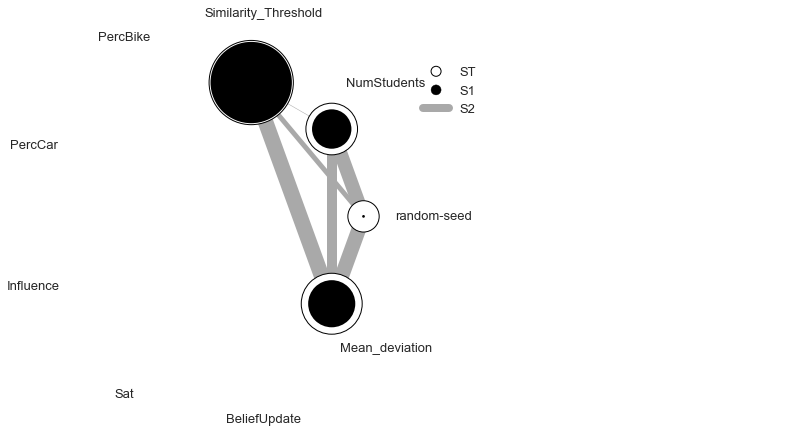

In [126]:
%matplotlib inline
import itertools
from math import pi


def normalize(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)


def plot_circles(ax, locs, names, max_s, stats, smax, smin, fc, ec, lw,
                 zorder):
    s = np.asarray([stats[name] for name in names])
    s = 0.01 + max_s * np.sqrt(normalize(s, smin, smax))

    fill = True
    for loc, name, si in zip(locs, names, s):
        if fc=='w':
            fill=False
        else:
            ec='none'

        x = np.cos(loc)
        y = np.sin(loc)

        circle = plt.Circle((x,y), radius=si, ec=ec, fc=fc, transform=ax.transData._b,
                            zorder=zorder, lw=lw, fill=True)
        ax.add_artist(circle)


def filter(sobol_indices, names, locs, criterion, threshold):
    if criterion in ['ST', 'S1', 'S2']:
        data = sobol_indices[criterion]
        data = np.abs(data)
        data = data.flatten() # flatten in case of S2

        filtered = ([(name, locs[i]) for i, name in enumerate(names) if
                     data[i]>threshold])
        filtered_names, filtered_locs = zip(*filtered)
    elif criterion in ['ST_conf', 'S1_conf', 'S2_conf']:
        raise NotImplementedError
    else:
        raise ValueError('unknown value for criterion')

    return filtered_names, filtered_locs


def plot_sobol_indices(sobol_indices, criterion='ST', threshold=0.01):

    max_linewidth_s2 = 15#25*1.8
    max_s_radius = 0.3

    # prepare data
    # use the absolute values of all the indices
    #sobol_indices = {key:np.abs(stats) for key, stats in sobol_indices.items()}

    # dataframe with ST and S1
    sobol_stats = {key:sobol_indices[key] for key in ['ST', 'S1']}
    sobol_stats = pd.DataFrame(sobol_stats, index=problem['names'])

    smax = sobol_stats.max().max()
    smin = sobol_stats.min().min()

    # dataframe with s2
    s2 = pd.DataFrame(sobol_indices['S2'], index=problem['names'],
                      columns=problem['names'])
    s2[s2<0.0]=0. #Set negative values to 0 (artifact from small sample sizes)
    s2max = s2.max().max()
    s2min = s2.min().min()

    names = problem['names']
    n = len(names)
    ticklocs = np.linspace(0, 2*pi, n+1)
    locs = ticklocs[0:-1]

    filtered_names, filtered_locs = filter(sobol_indices, names, locs,
                                           criterion, threshold)

    # setup figure
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks(ticklocs)

    ax.set_xticklabels(names)
    ax.set_yticklabels([])
    ax.set_ylim(top=1.4)
    legend(ax)

    # plot ST
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['ST'], smax, smin, 'w', 'k', 1, 9)

    # plot S1
    plot_circles(ax, filtered_locs, filtered_names, max_s_radius,
                 sobol_stats['S1'], smax, smin, 'k', 'k', 1, 10)

    # plot S2
    for name1, name2 in itertools.combinations(zip(filtered_names, filtered_locs), 2):
        name1, loc1 = name1
        name2, loc2 = name2

        weight = s2.loc[name1, name2]
        lw = 0.5+max_linewidth_s2*normalize(weight, s2min, s2max)
        ax.plot([loc1, loc2], [1,1], c='darkgray', lw=lw, zorder=1)

    return fig


from matplotlib.legend_handler import HandlerPatch
class HandlerCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = plt.Circle(xy=center, radius=orig_handle.radius)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

def legend(ax):
    some_identifiers = [plt.Circle((0,0), radius=5, color='k', fill=False, lw=1),
                        plt.Circle((0,0), radius=5, color='k', fill=True),
                        plt.Line2D([0,0.5], [0,0.5], lw=8, color='darkgray')]
    ax.legend(some_identifiers, ['ST', 'S1', 'S2'],
              loc=(1,0.75), borderaxespad=0.1, mode='expand',
              handler_map={plt.Circle: HandlerCircle()})


sns.set_style('whitegrid')
fig = plot_sobol_indices(Si3, criterion='ST', threshold=0.005)
fig.set_size_inches(7,7)

plt.savefig('ToMSTUDS.jpg')
plt.show()